### Import Library

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DIRECTORY = r"/content/drive/My Drive/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [ ]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)


In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.8, random_state=0)
(validX,TestX,validY,TestY)=train_test_split(testX,testY,test_size=0.7, random_state=0)

In [ ]:
print(trainX.shape)
print(testX.shape)
print(testY.shape)

(275, 224, 224, 3)
(1101, 224, 224, 3)
(1101, 2)


In [ ]:
print(validX.shape)
print(TestX.shape)

(330, 224, 224, 3)
(771, 224, 224, 3)


In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False


In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


In [ ]:
start_time = time.time()
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(validX, validY),
	validation_steps=len(validX) // BS,
	epochs=EPOCHS)
print("--- %s seconds ---" % (time.time() - start_time))

[INFO] training head...
Epoch 1/20
8/8 [==============================] - 20s 3s/step - loss: 0.3570 - accuracy: 0.8395 - val_loss: 0.2123 - val_accuracy: 0.9545
Epoch 2/20
8/8 [==============================] - 20s 2s/step - loss: 0.2235 - accuracy: 0.9342 - val_loss: 0.1555 - val_accuracy: 0.9697
Epoch 3/20
8/8 [==============================] - 20s 2s/step - loss: 0.2031 - accuracy: 0.9383 - val_loss: 0.1231 - val_accuracy: 0.9758
Epoch 4/20
8/8 [==============================] - 21s 3s/step - loss: 0.1408 - accuracy: 0.9671 - val_loss: 0.1070 - val_accuracy: 0.9818
Epoch 5/20
8/8 [==============================] - 20s 2s/step - loss: 0.1207 - accuracy: 0.9588 - val_loss: 0.0890 - val_accuracy: 0.9818
Epoch 6/20
8/8 [==============================] - 20s 2s/step - loss: 0.1025 - accuracy: 0.9712 - val_loss: 0.0779 - val_accuracy: 0.9818
Epoch 7/20
8/8 [==============================] - 20s 2s/step - loss: 0.0908 - accuracy: 0.9835 - val_loss: 0.0704 - val_accuracy: 0.9848
Epoch 8/20

In [ ]:

predIdxs = model.predict(TestX, batch_size=BS)

In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
print(classification_report(TestY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
from sklearn.metrics import confusion_matrix
confusion_matrix(TestY.argmax(axis=1),predIdxs)


              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       396
without_mask       0.99      1.00      1.00       375

    accuracy                           1.00       771
   macro avg       1.00      1.00      1.00       771
weighted avg       1.00      1.00      1.00       771



array([[393,   3],
       [  0, 375]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(TestY.argmax(axis=1),predIdxs)

0.9961089494163424

# New Section

In [ ]:
model.save("mask_detector.model", save_format="h5")

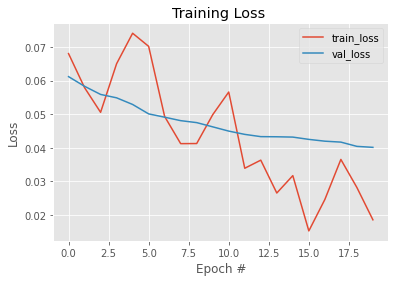

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

plt.title("Training Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("plot.png")

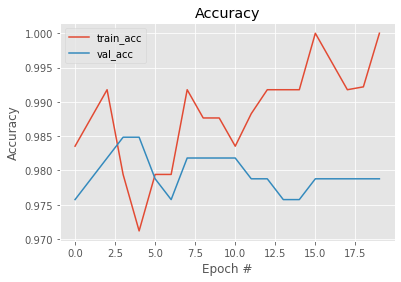

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("plot.png")